In [4]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

# 게임 환경 로딩

그리드의 크기는 자유롭게 조절하기 바랍니다. 크기를 작게 하면 우리의 DQN 에이전트가 보다 쉽게 작업을 수행할 것이며, 반대로 크게 하면 어려움을 배가시킬 것입니다. 

(역자주 : gridworld.py 라는 파일이 동일한 경로 내에 존재해야 합니다)

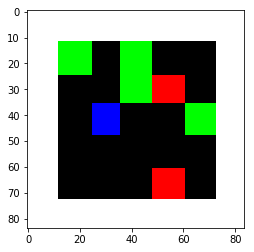

In [7]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

이 이미지는 우리의 간단한 게임 내의 시작 환경의 예시입니다. 

에이전트는 파란색 사각형을 위, 아래, 왼쪽, 오른쪽으로 이동시킵니다. 목표는 빨간색 사각형 (-1의 보상)을 피하여 녹색 사각형 (+1의 보상)까지 도달하는 것입니다. 세가지 블록의 위치는 매 에피소드마다 랜덤하게 변하게 됩니다.  

# 네트워크 구현

In [9]:
class Qnetwork():
    def __init__(self,h_size):
        #네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다 (flattening).
        #배열의 크기를 재조절해주고 4개의 컨벌루션 레이어를 거치면서 처리해 준다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #마지막 컨벌루션 레이어로부터의 출력값을 취한 후, 이를 어드밴티지 스트림과 값 스트림으로 분리한다. 
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #최종 Q-값을 얻기 위해 어드밴티지 스트림과 값 스트림을 조합해 준다. 
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #타겟 Q 값과 예측 Q 값 간의 제곱합 차를 취함으로써 비용을 구한다.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

# 경험 리플레이

아래 클래스는 경험과 샘플을 저장하고 랜덤하게 네트워크를 학습시킵니다. 

In [10]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

아래는 게임의 프레임의 사이즈를 조절해 주는 간단한 함수입니다.

In [11]:
def processState(states):
    return np.reshape(states,[21168])

아래 함수들은 1차 네트워크의 파라미터와 함께 타겟 네트워크의 파라미터를 업데이트하게 해줍니다.  

In [12]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

# 네트워크 학습

모든 학습 파라미터를 설정합니다. 

In [13]:
batch_size = 32 #각 학습 단계에서 사용할 경험의 수
update_freq = 4 #학습 단계 기준의 업데이트 주기 
y = .99 #타겟 Q-값에 대한 할인 계수
startE = 1 #시작 시 랜덤 액션의 가능성
endE = 0.1 #종료 시 랜덤 액션의 가능성
anneling_steps = 10000. #startE에서 endE로 줄어드는데 필요한 학습 단계 수
num_episodes = 10000 #네트워크를 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000 #학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 #허용되는 최대 에피소드 길이
load_model = False #저장된 모델을 로딩할 지 여부
path = "./dqn" #모델을 저장할 경로
h_size = 512 #어드밴티지 스트림과 값 스트림으로 분리되기 전의 마지막 컨벌루션 레이어의 크기
tau = 0.001 #타겟 네트워크를 제1네트워크로 업데이트시켜 가는 비율

In [14]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#랜덤 액션이 감소하는 비율을 설정 
e = startE
stepDrop = (startE - endE)/anneling_steps

#전체 보상과 에피소드 별 단계 수를 저장할 리스트를 생성
jList = []
rList = []
total_steps = 0

#모델이 저장될 경로 생성
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #환경을 리셋하고 첫번째 관찰 얻기
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #Q-네트워크
        while j < max_epLength: #만약 에이전트가 블록에 도달하기 위해 200회 이상 시도하면 종료
            j+=1
            # Q-네트워크로부터 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택한다.
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #에피소드 버퍼에 경험을 저장
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #경험에서 특정 부분을 랜덤하게 획득
                    #타겟 Q-값에 대해 double DQN 업데이트를 수행
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #타겟 값을 이용해 네트워크를 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 0.7 1
1000 1.6 1
1500 3.0 1
2000 2.3 1
2500 1.5 1
3000 2.8 1
3500 2.3 1
4000 2.1 1
4500 2.7 1
5000 0.7 1
5500 1.7 1
6000 2.3 1
6500 1.3 1
7000 2.2 1
7500 3.0 1
8000 2.5 1
8500 3.7 1
9000 1.9 1
9500 2.3 1
10000 1.3 1
10500 3.3 0.9549999999999828
11000 3.5 0.9099999999999655
11500 1.7 0.8649999999999483
12000 2.6 0.819999999999931
12500 1.5 0.7749999999999138
13000 3.0 0.7299999999998965
13500 3.2 0.6849999999998793
14000 0.8 0.639999999999862
14500 1.6 0.5949999999998448
15000 1.8 0.5499999999998275
15500 1.5 0.5049999999998103
16000 1.7 0.4599999999998177
16500 1.4 0.41499999999982823
17000 1.5 0.36999999999983874
17500 1.3 0.32499999999984924
18000 0.7 0.27999999999985975
18500 0.4 0.23499999999986562
19000 1.9 0.18999999999986225
19500 1.3 0.14499999999985888
20000 1.3 0.09999999999985551
20500 0.2 0.09999999999985551
21000 -0.3 0.09999999999985551
21500 0.9 0.09999999999985551
22000 0.8 0.09999999999985551
22500 0.5 0.09999999999985551
23000 1.7 0.09999999999985551
2

KeyboardInterrupt: 

# 네트워크 학습 체크하기

시간의 흐름에 따른 평균 보상

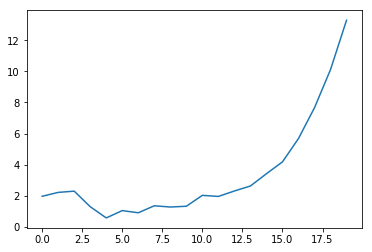

In [15]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)